# NTI Final Project
### ML model for predict Heart Disease
---

## 1- Importing the necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

## 2- load & Show data

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### #Check on data (NaN & duplicated)

In [3]:
df.shape

(918, 12)

In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
913    False
914    False
915    False
916    False
917    False
Length: 918, dtype: bool

## 3- Visualize full dataset before split

In [7]:
print("\n=== Full Dataset Info ===")
print(df.info())
print("\nValue counts of target:\n", df['HeartDisease'].value_counts())


=== Full Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

Value counts of target:
 HeartDisease
1    508
0    410
Name: count, dtype: int64


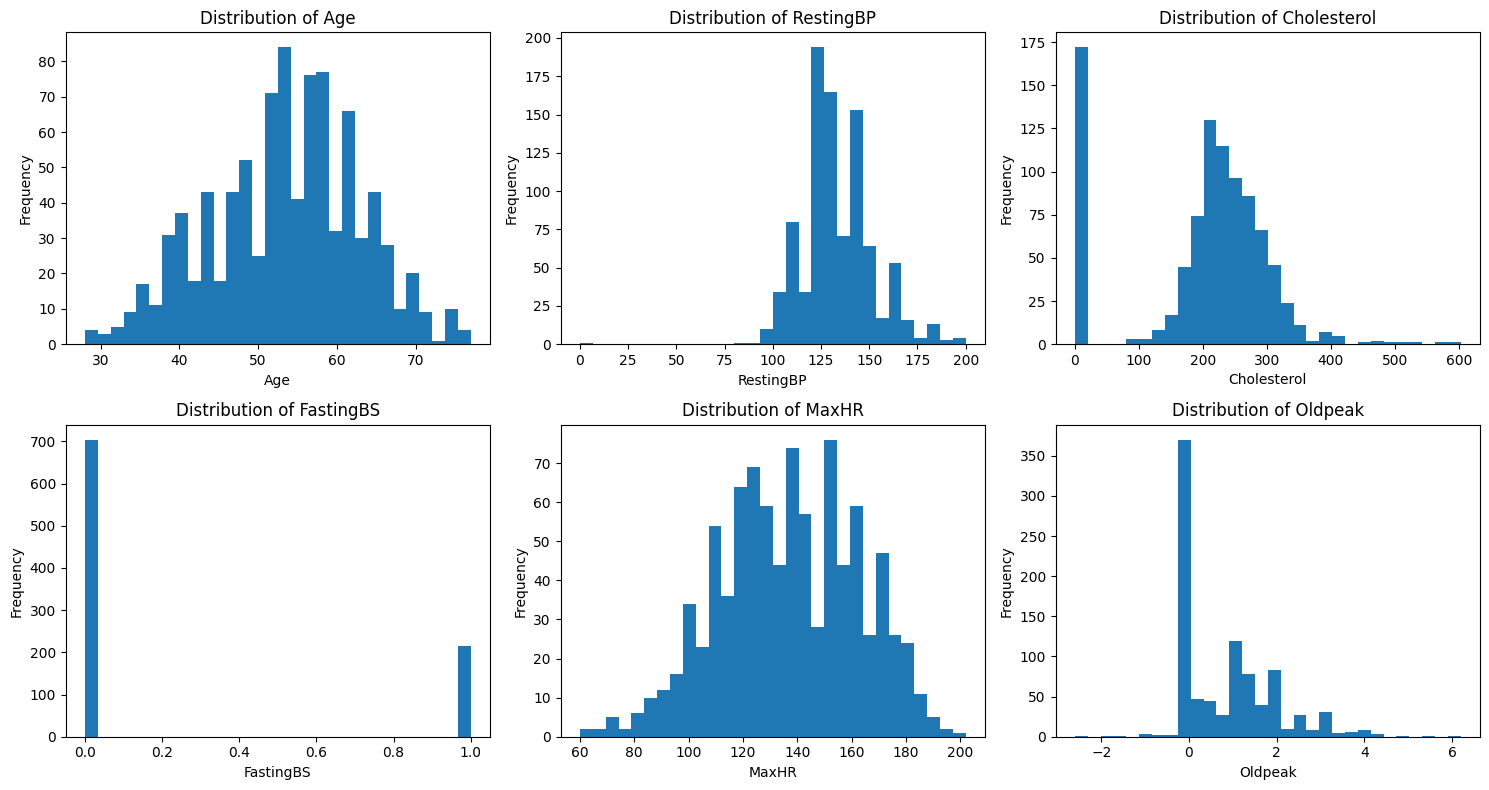

In [8]:
num_cols = df.select_dtypes(include=[np.number]).columns.drop('HeartDisease')
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    ax.hist(df[col], bins=30)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
for ax in axes[len(num_cols):]:
    fig.delaxes(ax)
plt.tight_layout()
plt.show()

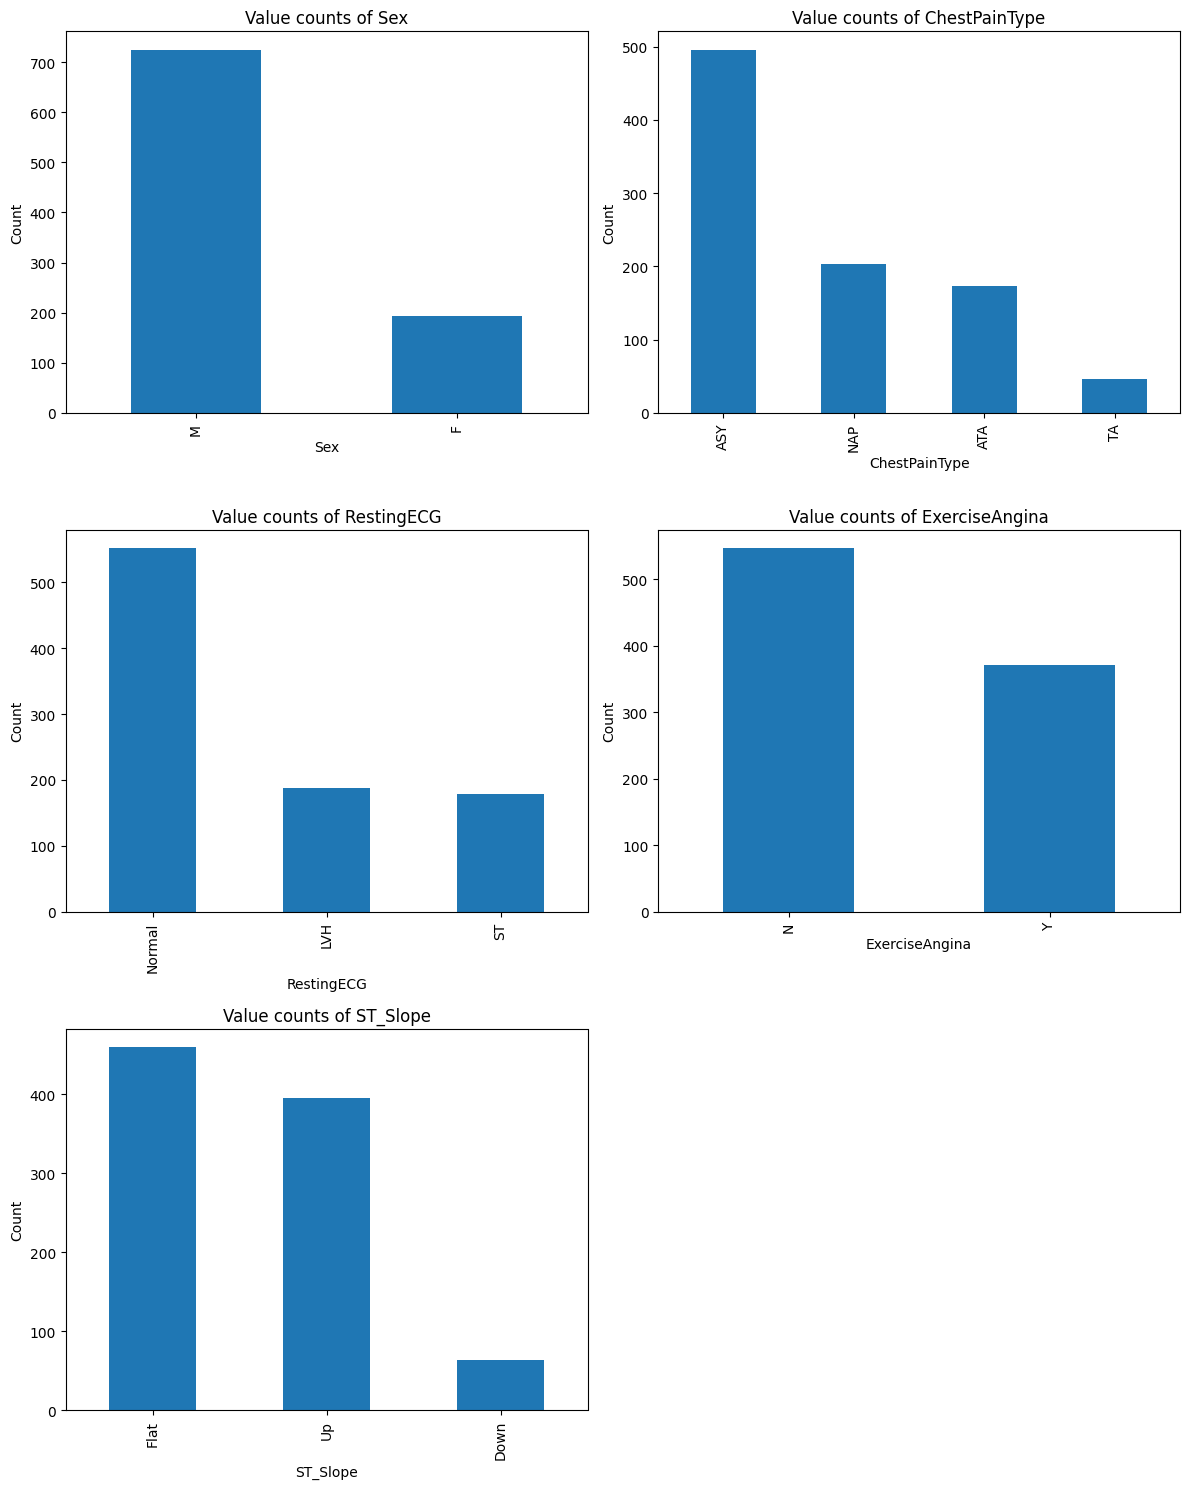

In [9]:
cat_cols = df.select_dtypes(exclude=[np.number]).columns
n_cols = 2
n_rows = int(np.ceil(len(cat_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()
for ax, col in zip(axes, cat_cols):
    df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Value counts of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
for ax in axes[len(cat_cols):]:
    fig.delaxes(ax)
plt.tight_layout()
plt.show()

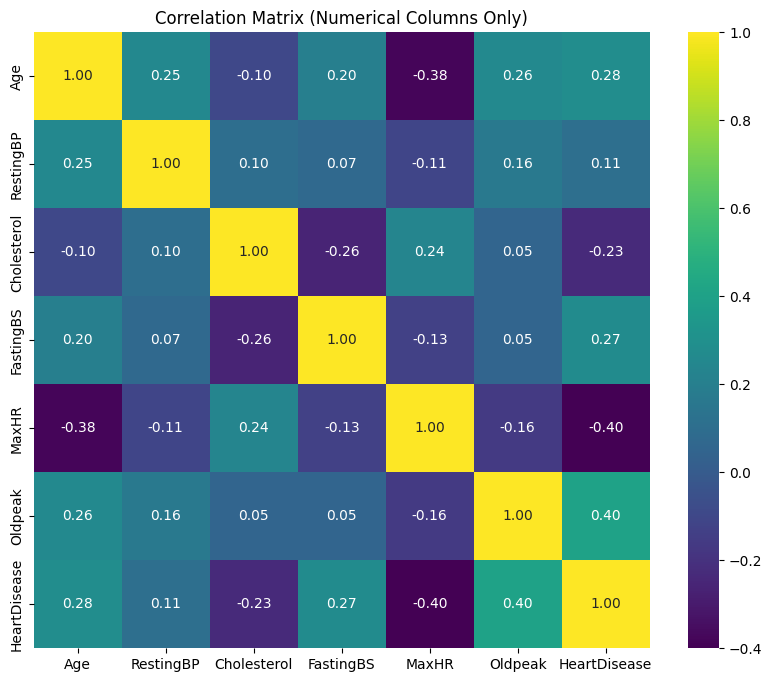

In [10]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f", square=True)
plt.title('Correlation Matrix (Numerical Columns Only)')
plt.show()

## 4- Split data

In [11]:
x = df.drop('HeartDisease', axis='columns')
y = df.HeartDisease
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
print("\n=== Train/Test Split ===")
print("Train shape:", x_train.shape, "| Test shape:", x_test.shape)
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))


=== Train/Test Split ===
Train shape: (734, 11) | Test shape: (184, 11)

Train class distribution:
 HeartDisease
1    0.553134
0    0.446866
Name: proportion, dtype: float64

Test class distribution:
 HeartDisease
1    0.554348
0    0.445652
Name: proportion, dtype: float64


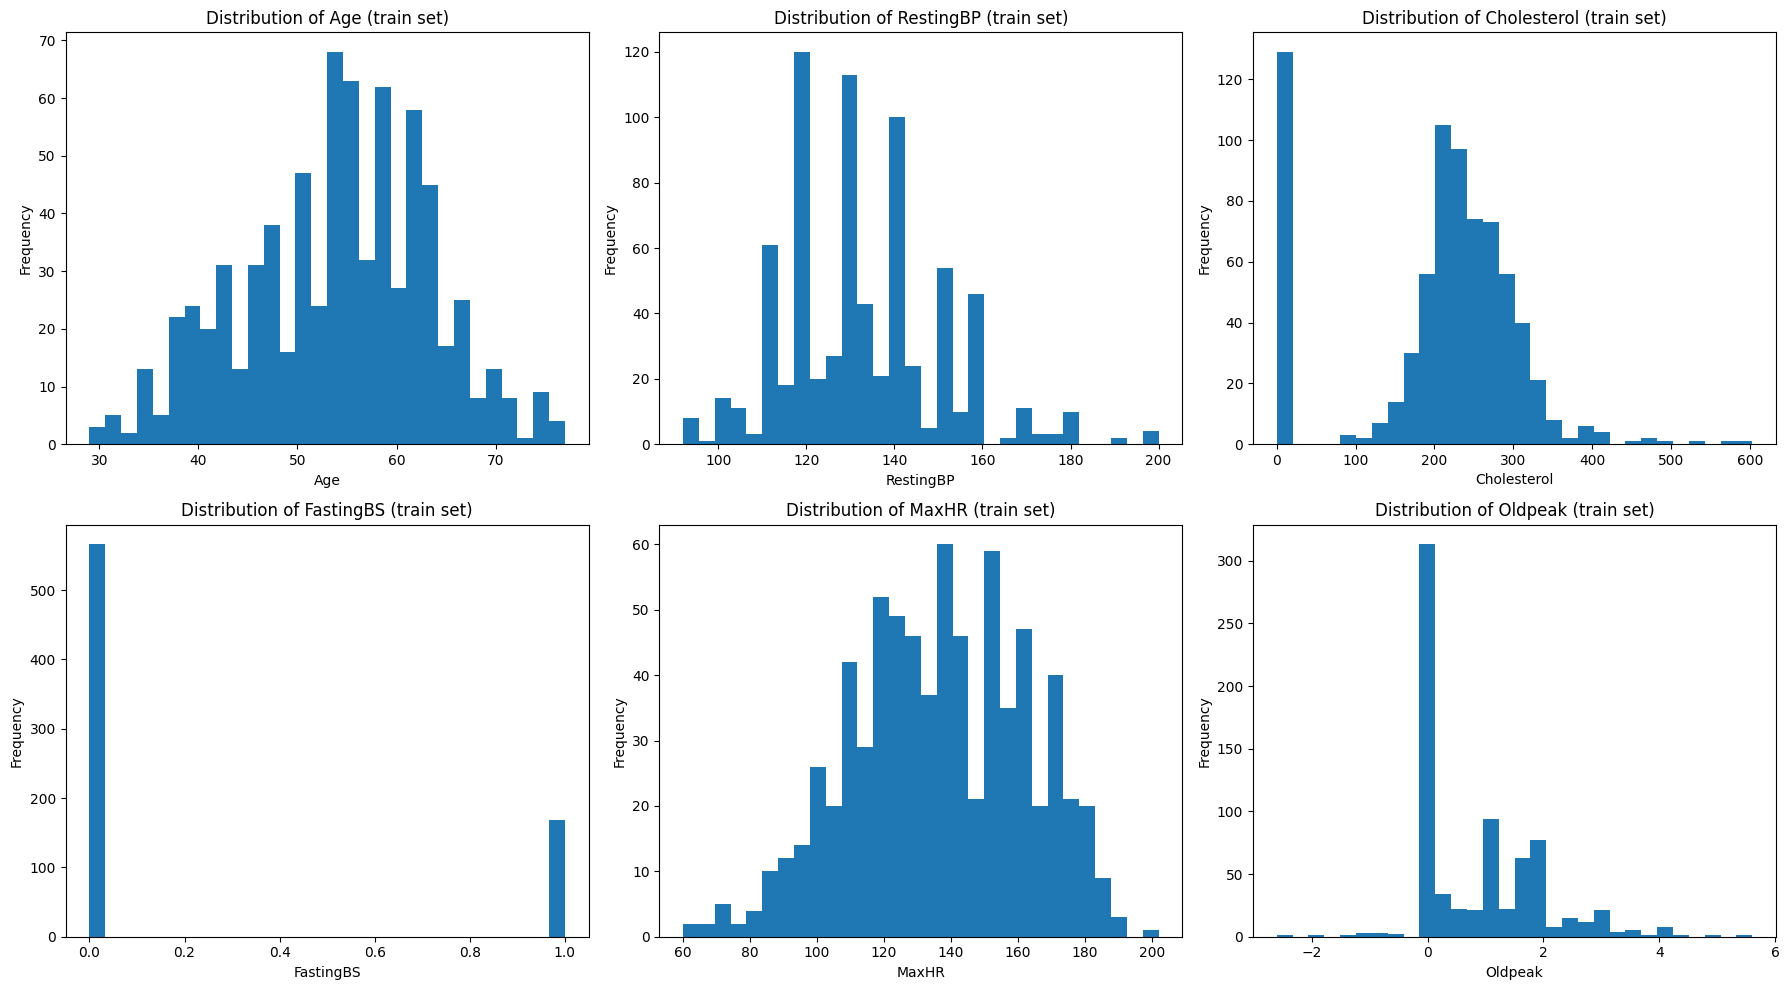

In [13]:
train_visual = x_train.select_dtypes(include=[np.number]).columns
n_cols = 3
n_rows = int(np.ceil(len(train_visual) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()
for ax, col in zip(axes, train_visual):
    ax.hist(x_train[col], bins=30)
    ax.set_title(f'Distribution of {col} (train set)')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
for ax in axes[len(train_visual):]:
    fig.delaxes(ax)
plt.tight_layout()
plt.show()

## 5- Preprocessing operation

In [14]:
cat_cols = x.select_dtypes(exclude=[np.number]).columns.tolist()
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), x_train.select_dtypes(include=[np.number]).columns),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

## 6- Define models

In [15]:
models = {
    'SVC_linear': SVC(kernel='linear', random_state=42),
    'SVC_poly': SVC(kernel='poly', degree=3, random_state=42, gamma='auto'),
    'SVC_rbf': SVC(kernel='rbf', random_state=42, gamma=0.7),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'GaussianNB': GaussianNB()
}

## 7- Train, evaluate on test and cross-validate

In [22]:
results = {}

print("\n{:<20} {:<20} {:<20}".format("Model", "Mean CV Accuracy", "Test Accuracy"))
print("="*60)

for name, model in models.items():
    pipe = Pipeline([('prep', preprocessor), ('clf', model)])
    
    # Cross-validation
    cv_scores = cross_val_score(pipe, x_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    test_acc = accuracy_score(y_test, y_pred)
    
    results[name] = {'cv_mean': np.mean(cv_scores), 'test_acc': test_acc}
    
    # Print summary
    print("{:<20} {:<20.3f} {:<20.3f}".format(name, np.mean(cv_scores), test_acc))


Model                Mean CV Accuracy     Test Accuracy       
SVC_linear           0.854                0.880               
SVC_poly             0.866                0.891               
SVC_rbf              0.820                0.848               
LogisticRegression   0.854                0.886               
GaussianNB           0.856                0.913               


In [23]:
for name, model in models.items():
    pipe = Pipeline([('prep', preprocessor), ('clf', model)])
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)

    print(f"\n{'='*15} {name} {'='*15}")
    report = classification_report(y_test, y_pred, output_dict=False)
    print(report)



=============== SVC_linear ===============
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        82
           1       0.86      0.93      0.90       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.88       184
weighted avg       0.88      0.88      0.88       184


=============== SVC_poly ===============
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        82
           1       0.91      0.89      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184


=============== SVC_rbf ===============
              precision    recall  f1-score   support

           0       0.92      0.72      0.81        82
           1       0.81      0.95      0.87       102

    accuracy                           0.85       184
 

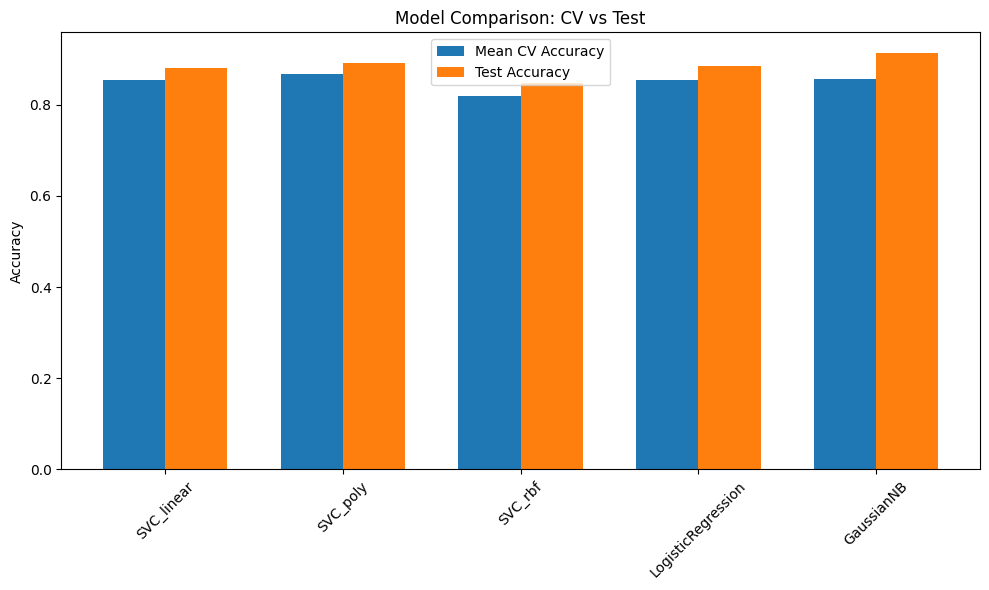

In [24]:
names = list(results.keys())
cv_means = [results[n]['cv_mean'] for n in names]
test_accs = [results[n]['test_acc'] for n in names]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, cv_means, width, label='Mean CV Accuracy')
plt.bar(x + width/2, test_accs, width, label='Test Accuracy')
plt.xticks(x, names, rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Comparison: CV vs Test')
plt.legend()
plt.tight_layout()
plt.show()